In [ ]:
import torch
import numpy as np
import networkx as nx
from olga import OLGA
from torch_geometric.nn import GAE
from oneclass import one_class_loss, one_class_masking, One_Class_GNN_prediction, EarlyStopping
from torch_geometric.utils.convert import from_networkx
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from matplotlib import animation

In [15]:
def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    center = centers[i].detach().cpu().numpy()
    r = radiuss[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], s=100, c=G.label, cmap="hsv", vmin=-2, vmax=3)
    ax.scatter(center[0], center[1], s=35, c='red', cmap="hsv", vmin=-2, vmax=3)
    circle = plt.Circle((center[0], center[1]), r, color='red', fill=False)
    plt.gca().add_artist(circle)
    plt.title(f'Ep {i} | loss: {losses[i]:.4f} | Rec: 'f'{losses_rec[i]:.4f} |'
              ' Ocl: 'f'{losses_ocl[i]:.4f} | F1: {accuracies[i]*100:.2f}%', fontsize=13, pad=40)

    plt.xlim([-1, 1])
    plt.ylim([-1, 1])

In [36]:
learn_radius = False
learn_center = False

dt = 'TUANDROMD'
k = 'k=1'

file = '../../datasets/' + dt + '/' + k + '/' + dt + '_' + k +'_fold=0.gpickle'

g = nx.read_gpickle(file)

mask, t_mask, mask_unsup, t_mask_unsup = one_class_masking(g, True)

G = from_networkx(g)

hidden1 = 48

hidden2 = 2

c = [0] * hidden2
r = [0.35]
c = torch.Tensor(c)
r = torch.Tensor(r)

model_ocl = OLGA(len(G.features[0]), [hidden1, hidden2])
model = GAE(model_ocl)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

patience = 300

stopper = EarlyStopping(patience)

centers = []
embeddings = []
losses_ocl = []
losses_rec = []
accuracies = []
radiuss = []
losses = []

best_embeddings, best_radius, best_center = [], 0, []
# Training loop

g_unsup = g.subgraph(t_mask_unsup)
G_unsup = from_networkx(g_unsup)

loss_ocl = 0
recon_loss_unsup = 0

radius = r
center = c

for epoch in range(10001):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass

    learned_representations = model.encode(G.features.float(), G.edge_index)

    if epoch < patience / 2:
        loss = model.recon_loss(learned_representations, G.edge_index)
    else:
        loss_ocl = one_class_loss(center, radius, learned_representations, mask)

        recon_loss_unsup = model.recon_loss(learned_representations[mask_unsup], G_unsup.edge_index)

        loss = loss_ocl + recon_loss_unsup

    f1 = One_Class_GNN_prediction(center, radius, learned_representations, g, 'test', True)['macro avg']['f1-score']

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | F1: {f1*100:.2f}% | Loss_R: {recon_loss_unsup:.5f} |  Loss_O: '
          f''f'{loss_ocl:.5f} | R: {torch.abs(torch.mean(radius)):.2f}')

    stop, best_embeddings, best_radius, best_center, best_epoch = stopper.step(f1, loss, epoch, radius, center,
                                                                               learned_representations)

    embeddings.append(learned_representations)
    losses_ocl.append(loss_ocl)
    losses_rec.append(recon_loss_unsup)
    losses.append(loss)
    accuracies.append(f1)
    centers.append(center)
    radiuss.append(radius)

    if stop:
        break

One_Class_GNN_prediction(best_center, best_radius, best_embeddings, g, 'test', False)

Epoch   0 | Loss: 1.31271 | F1: 81.66% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   1 | Loss: 1.30621 | F1: 81.77% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   2 | Loss: 1.29933 | F1: 79.75% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   3 | Loss: 1.29396 | F1: 75.88% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   4 | Loss: 1.28785 | F1: 75.57% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   5 | Loss: 1.28080 | F1: 75.56% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   6 | Loss: 1.27771 | F1: 74.74% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   7 | Loss: 1.27348 | F1: 74.81% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   8 | Loss: 1.26818 | F1: 74.60% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch   9 | Loss: 1.26702 | F1: 74.55% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch  10 | Loss: 1.26078 | F1: 74.90% | Loss_R: 0.00000 |  Loss_O: 0.00000 | R: 0.35
Epoch  11 | Loss: 1.25734 | F1: 73.23% | Loss_R: 0.000

/tmp/ipykernel_32177/4021319867.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax.scatter(center[0], center[1], s=35, c='red', cmap="hsv", vmin=-2, vmax=3)


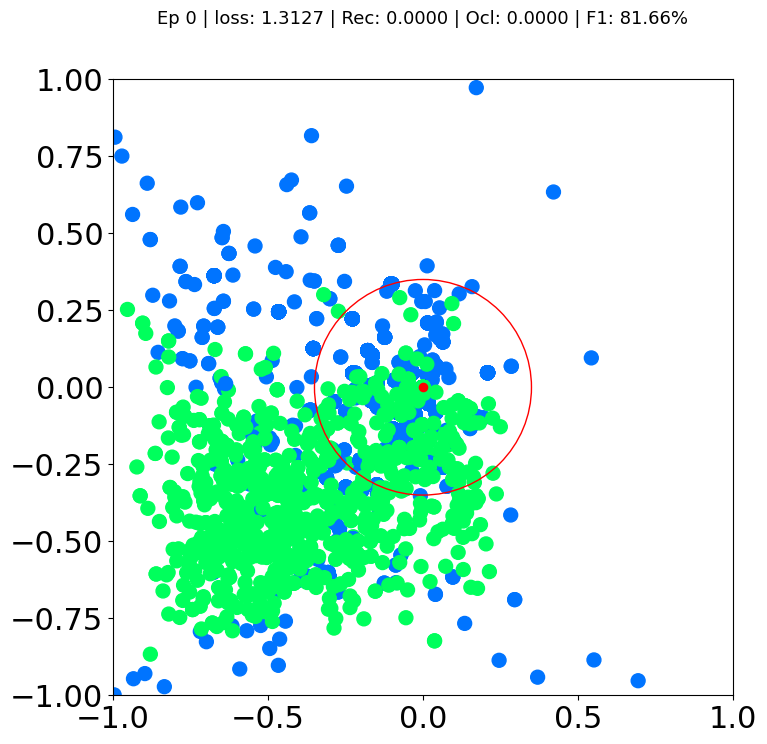

In [37]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

anim = animation.FuncAnimation(fig, animate, np.arange(0, epoch-300, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

display(html)

/tmp/ipykernel_32177/354272311.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax.scatter(center[0], center[1], s=35, c='red', cmap="hsv", vmin=-2, vmax=3)


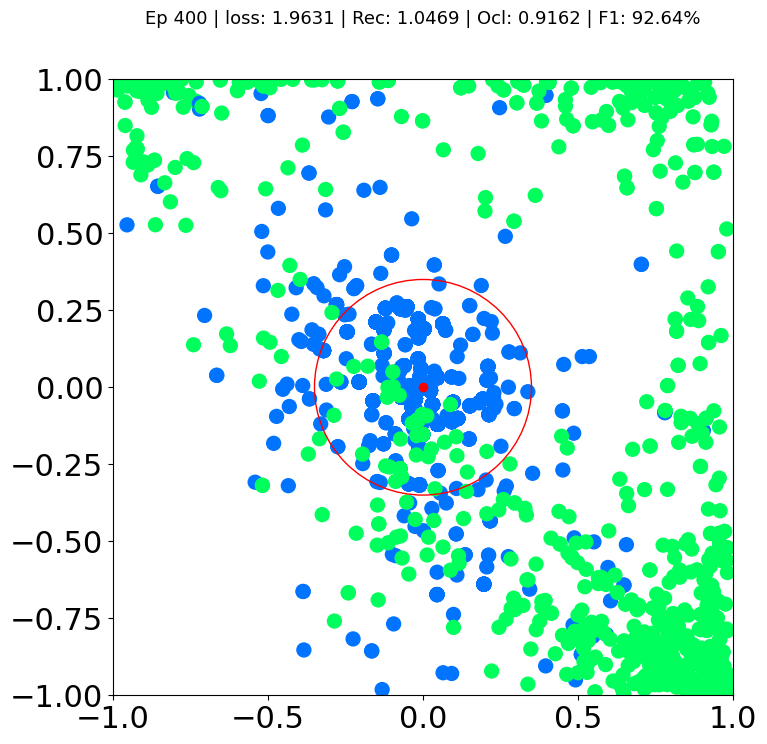

In [42]:
i = 400
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
embed = embeddings[i].detach().cpu().numpy()
center = centers[i].detach().cpu().numpy()
r = radiuss[i].detach().cpu().numpy()
ax.clear()
ax.scatter(embed[:, 0], embed[:, 1], s=100, c=G.label, cmap="hsv", vmin=-2, vmax=3)
ax.scatter(center[0], center[1], s=35, c='red', cmap="hsv", vmin=-2, vmax=3)
circle = plt.Circle((center[0], center[1]), r, color='red', fill=False)
plt.gca().add_artist(circle)
plt.title(f'Ep {i} | loss: {losses[i]:.4f} | Rec: 'f'{losses_rec[i]:.4f} |'
          ' Ocl: 'f'{losses_ocl[i]:.4f} | F1: {accuracies[i]*100:.2f}%', fontsize=13, pad=40)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()